## Vanilla FM intro

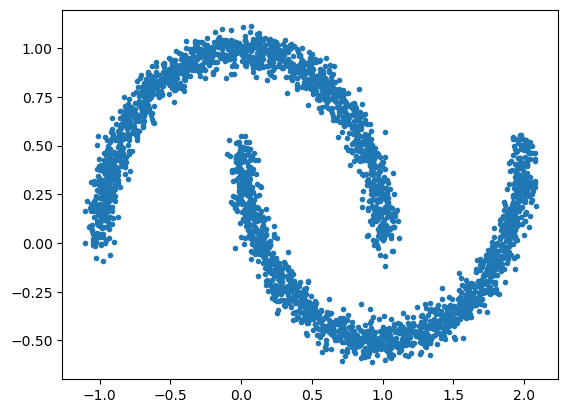

In [23]:

import matplotlib.pyplot as plt
from tqdm import tqdm
from torchdiffeq import odeint
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_moons

device = 'cuda' # cuda, cpu

x, _ = make_moons(n_samples=3000,noise=0.05)
x = torch.from_numpy(x).float().cuda()

plt.figure()
plt.plot(x[:,0].cpu().numpy(),x[:,1].cpu().numpy(), '.')
plt.show()


In [24]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.elu(layer(x))
        x = self.layers[-1](x)
        return x
    
    def v(self, t, x):
        return self(torch.hstack((t, x)))
    
    def solve(self, t, x):
        t = torch.ones((x.shape[0],1), device=x.device) * t
        return self.v(t, x)

### Define Loss function and train

In [25]:

def FlowMatchingLoss(model, x,sig_min = 1e-4):
    t = torch.rand(x.shape[0],1).to(device)
    z = torch.randn_like(x).to(device)
    
    y = (1 - t) * x + (sig_min + (1 - sig_min) * t) * z 
    u = (1 - sig_min) * z - x 

    return ((model.v(t, y) - u)**2).mean()

flow = MLP([3,256,256,256,256,2])
flow.to(device)

# Training
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
loss_all = []

for epoch in tqdm(range(10000)):
    subset = torch.randint(0, len(x), (256,))
    x_batch = x[subset]

    optimizer.zero_grad()
    l = FlowMatchingLoss(flow,x_batch)
    l.backward()
    optimizer.step()

    loss_all.append(l.item())

100%|██████████| 10000/10000 [00:09<00:00, 1005.67it/s]


### Here we use a standard ODE integrator for inference

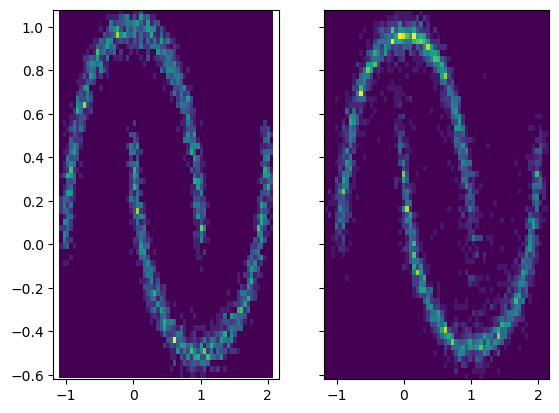

In [26]:

eps = torch.randn(4096, 2).to(device)
ode_steps = 2
with torch.no_grad():
    traj = odeint(flow.solve, eps,torch.linspace(1, 0., ode_steps, device='cpu').to(device),rtol=1e-4,atol=1e-4)
x_ = traj[-1].detach().cpu()

fig, ax = plt.subplots(1,2,sharex=True,sharey=True)
ax[0].hist2d(x[:, 0].cpu().numpy(), x[:, 1].cpu().numpy(), bins=64)
ax[1].hist2d(x_[:, 0], x_[:, 1], bins=64)
plt.show()